Recommendation System based on data from the MovieLens web site with:
- 943 users
- 1682 items
- 100000 ratings

Import necessary packages:

In [232]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

Create a function to read the original dataset:

In [233]:

columns = ["user_id", "item_id", "rating", "timestamp"]
# Function to read textfile dataset and load it as a Pandas DataFrame
def loadData(file, columns):
    df = pd.read_table(file, sep='\t')
    df.columns = columns
    return df

u_data = loadData("/Users/patrick.orourke/Desktop/ml-100k/u.data",columns)
u_data.head(5)

,user_id,item_id,rating,timestamp
0,186,302,3,891717742
1,22,377,1,878887116
2,244,51,2,880606923
3,166,346,1,886397596
4,298,474,4,884182806


Find the shape of the loaded dataset:

In [234]:
u_data.shape

(99999, 4)

Find the number of unique elements in each column of the dataset:

In [235]:
print("The number of unique users in the data: ", u_data['user_id'].nunique())
print("The number of unique movies in the data: ", u_data['item_id'].nunique())
print("The number of unique ratings in the data: ", u_data['rating'].nunique())
print("The number of unique timestamps in the data: ", u_data['timestamp'].nunique())

The number of unique users in the data:  943
The number of unique movies in the data:  1682
The number of unique ratings in the data:  5
The number of unique timestamps in the data:  49282


Examine the distribution of the movie ratings by generating a bar chart:

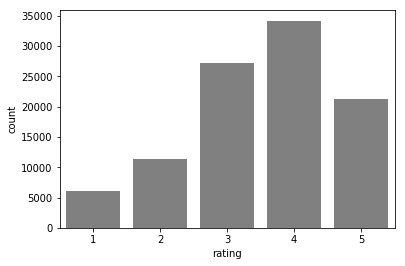

In [236]:
# Examine the distribution of movie ratings
import matplotlib.pyplot as plt
#pd.options.display.mpl_style = 'default'
# u_data['rating'].plot(kind='hist')
sns.countplot(u_data['rating'], color='gray')

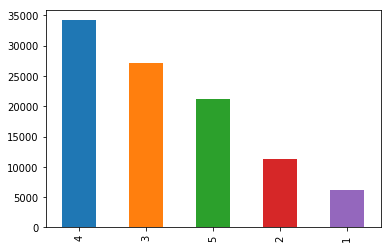

In [237]:
u_data['rating'].value_counts().plot(kind='bar')

Generate the number of elemens for each column of the dataset:

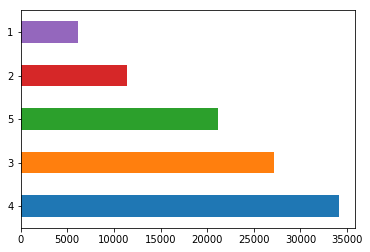

In [238]:
u_data['rating'].value_counts().plot(kind='barh')

In [239]:
# Build Recommendation Engine

In [240]:
tempData = u_data[['user_id', 'item_id', 'rating']]
tempData.head(5)

,user_id,item_id,rating
0,186,302,3
1,22,377,1
2,244,51,2
3,166,346,1
4,298,474,4


Create a Pandas Dataframe which shows the relationship of users and movies.
Subtract the mean of each row to scala the rows.

In [241]:
#userItemDF = pd.pivot_table(data = tempData,
#                            index='user_id', columns='item_id', fill_value='rating')
#userItemDF.head()

userItemDF = pd.pivot_table(data = tempData, 
                            index='user_id', 
                            columns='item_id',
                            fill_value=0,
                            values = 'rating')

userItemMatrix = userItemDF.apply(func= lambda x: x - np.mean(x), axis = 1)
userItemMatrix = userItemDF.values.astype(float)
userItemMatrix.shape

(943, 1682)

Look at the fitsy 5 rows of the userItemMatrix:

In [242]:
userItemMatrix[:5,:]

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 3., 0., ..., 0., 0., 0.]])

In [243]:
print("Shape of the user item matrix: ", userItemDF.shape)

Shape of the user item matrix:  (943, 1682)


In [244]:
## Number of ratings by user
top_users = np.sum(userItemMatrix, axis = 1).argsort()[-10:][::-1]
top_bought_bonds =  np.sum(userItemMatrix, axis = 0).argsort()[-10:][::-1]

In [245]:
# Top users which purchased different movies

In [246]:
userItemDF.iloc[top_users].index

Int64Index([450, 655, 13, 416, 276, 303, 7, 846, 59, 234], dtype='int64', name='user_id')

In [247]:
# Measuring sparsity from the user item matrix

In [248]:
cnt_of_zero_cells = np.sum(userItemMatrix == 0)
cnt_of_one_cells = np.sum(userItemMatrix >= 0)
print("sparsity percentage: ", cnt_of_zero_cells/(cnt_of_zero_cells + cnt_of_one_cells))

sparsity percentage:  0.4837254614121949


In [249]:
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [250]:
# Truncated SVD (like LSA probabilistic matrix factorization)

In [251]:
U, s, Vt = svds(userItemMatrix, k=150)
Vt.shape
# For user-user .... use U
# i = np.random.randint(low = 0, high=1070, size = 1)[0]
#reconstructed_matrix = np.matmul(np.matmul(U, np.diag(s)), Vt)
# print("decomposed sum: ", sum(reconstructed_matrix[i]))
# print("original sum: ", sum(userItemMatrix[i]))
# print("RMSE: ", np.sqrt(np.mean((userItemMatrix - reconstructed_matrix) ** 2)))

#svd = SVD(n_components=150, algorithm="randomized", n_iter=10, random_state=100)
#user_matrix = svd.fit_transform(userItemMatrix)
#print("User matrix shape: ", user_matrix.shape)
#print("Total explained variance percentage by selected components: ", np.sum(svd.explained_variance_ratio_) * 100.0)
#item_matrix = np.matmul(np.diag(svd.singular_values_), svd.components_).T
#item_matrix = np.matmul(userItemMatrix.T, np.matmul(user_matrix ,np.diag(svd.singular_values_)))
#print("Item matrix shape: ", item_matrix.shape)

(150, 1682)

In [252]:
# ?? How was corrDF defined?

In [253]:
#corrDF = pd.DataFrame(data = np.corrcoef(item_matrix), columns=userItemDF.columns)
from sklearn.metrics.pairwise import cosine_similarity
corrDF = cosine_similarity(X = Vt.T)
corrDF.shape
corrDF = pd.DataFrame(data=corrDF, columns=userItemDF.columns, index=userItemDF.columns)
# Columns = items, indexes =. users .... use latter for user-user
corrDF.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
item_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.040109,-0.010311,0.025244,-0.056239,0.031500,-0.006896,-0.018654,0.014580,0.059609,...,0.038575,-0.024017,-0.050575,-0.050575,0.033138,0.049797,0.049797,0.049797,0.016134,0.052618
2,0.040109,1.000000,-0.016780,0.065758,-0.042892,0.126013,-0.002664,-0.094529,-0.004159,0.016922,...,0.105296,-0.110598,-0.052890,-0.052890,0.029045,-0.043946,-0.043946,-0.043946,0.019092,0.009707
3,-0.010311,-0.016780,1.000000,-0.012935,-0.071125,-0.018411,-0.023646,-0.026627,0.021597,0.056490,...,0.092386,0.063366,-0.005213,-0.005213,0.173008,0.021112,0.021112,0.021112,-0.067158,0.070885
4,0.025244,0.065758,-0.012935,1.000000,0.007296,-0.062350,-0.048994,0.003986,0.102691,-0.024588,...,-0.004088,-0.051162,0.110311,0.110311,-0.047873,0.000813,0.000813,0.000813,-0.011099,0.044613
5,-0.056239,-0.042892,-0.071125,0.007296,1.000000,0.042605,-0.052533,0.000499,0.024171,-0.145256,...,-0.062187,-0.020264,0.007201,0.007201,-0.052948,-0.002688,-0.002688,-0.002688,0.040368,0.226578


/Users/patrick.orourke/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


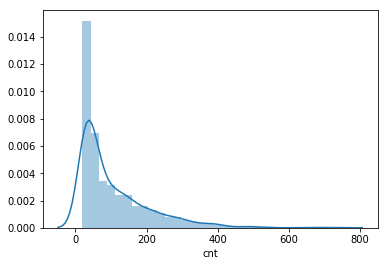

In [254]:
tempDF = u_data.groupby("user_id")["item_id"].count().reset_index()
tempDF.columns = ["user_id", "cnt"]
sns.distplot(tempDF["cnt"])
#tempDF["cnt"] >=  

In [255]:
# Testing latent semantic analysis technique by generating recommendations based on the past ratings

In [256]:
user_list = u_data["user_id"].tolist()

random_index = np.random.randint(low = 0, high=len(user_list), size = 1)[0]

#random_index = np.random.randint(low = 0, high=len(user_list), size = 1)[0]
counter_user_id = user_list[random_index]
rating_list = list(u_data[u_data["user_id"] == counter_user_id]["rating"])
item_list = list(u_data[u_data["user_id"] == counter_user_id]["item_id"])
''' Getting random users and ratings made'''
item_rating_info = list(zip(item_list, rating_list))
print("Counter party ", counter_user_id)
#print("Ratings: ", item_rating_info)
not_rated_items = list(set(userItemDF.columns) - set(item_list))
random_item_index = np.random.randint(low = 0, high = len(not_rated_items), size = 1)[0]
print("want to rate item: ", not_rated_items[random_item_index])


item_rating_similarity_list = []
for item, rat in item_rating_info:
    item_rating_similarity_list.append((item, rat, corrDF.loc[not_rated_items[random_item_index]][item]))

item_rating_similarity_list

Counter party  747
want to rate item:  1661


[(228, 4, -0.0986545457489314),
 (25, 3, 0.11292459103468182),
 (108, 4, -0.07546037607905869),
 (208, 5, -0.1246680429425127),
 (23, 5, -0.02049323382979635),
 (223, 5, -0.003084600940459429),
 (432, 5, 0.06668084924155489),
 (48, 5, -0.03756656587869924),
 (1050, 3, -0.04100562823614401),
 (486, 5, 0.08871766006947354),
 (1375, 4, 0.09477189511169155),
 (783, 1, -0.07864443609502757),
 (116, 4, -0.0895299990706114),
 (303, 5, -0.01385843388643061),
 (650, 4, -0.04639486600655932),
 (173, 3, -0.06890863408131034),
 (180, 5, 0.05236351343740019),
 (531, 4, -0.03948265107884427),
 (279, 4, 0.062067179176144134),
 (661, 5, 0.015620961975836324),
 (132, 4, -0.08959900707658859),
 (44, 2, -0.03839618509836644),
 (835, 3, -0.05613638673326521),
 (183, 5, -0.11256923768118171),
 (292, 4, -0.014320199793909649),
 (443, 5, 0.014069498848377899),
 (654, 5, -0.0395345831003938),
 (87, 5, 0.1951371377342479),
 (467, 4, -0.053888214869427166),
 (1194, 5, 0.08752382913265556),
 (211, 5, -0.04198118

In [264]:
recommended_score = 0.0
for item, rat, similarity_score in item_rating_similarity_list:
    recommended_score += (similarity_score * rat)

recommended_score/sum([score for _, _, score in item_rating_similarity_list])

4.016839335621703

In [265]:
# Content-based Recommendations

In [266]:

columns_1 = ["movie id", "movie title", "release date", "video release date",
              "IMDb URL","unknown", "Action", "Adventure", "Animation",
              "Children's", "Comedy" ,"Crime" , "Documentary", "Drama", "Fantasy" ,
              "Film-Noir","Horror" ,"Musical", "Mystery","Romance", "Sci-Fi",
              "Thriller", "War","Western"]
# Function to read textfile dataset and load it as a Pandas DataFrame
def loadData(file, columns):
    df = pd.read_table(file, sep='|', encoding='utf-8')
    df.columns = columns
    return df

#u_data = loadData(r"/Users/patrick.orourke/Desktop/ml-100k/u.item",columns)
#u_data.head(5)

itemdf = pd.read_table(r"/Users/patrick.orourke/Desktop/ml-100k/u.item", sep="|", encoding='latin-1', 
              header=None)
itemdf.columns = columns_1
itemdf.head()

#list() + list(itemdf.columns[5:])
selectedCols = [itemdf.columns[0]] + list(itemdf.columns[5:])
#[1] + [2, 3]
itemdfTemp = itemdf[selectedCols]
print(itemdfTemp)

      movie id  unknown  Action  Adventure  Animation  Children's  Comedy  \
0            1        0       0          0          1           1       1   
1            2        0       1          1          0           0       0   
2            3        0       0          0          0           0       0   
3            4        0       1          0          0           0       1   
4            5        0       0          0          0           0       0   
5            6        0       0          0          0           0       0   
6            7        0       0          0          0           0       0   
7            8        0       0          0          0           1       1   
8            9        0       0          0          0           0       0   
9           10        0       0          0          0           0       0   
10          11        0       0          0          0           0       0   
11          12        0       0          0          0           0       0   

In [267]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=4, n_jobs=-1)
neighFit = neigh.fit(itemdfTemp) 
distance, neighb = neighFit.kneighbors(itemdfTemp)
neighb.shape
neighb

array([[   0,    7,    3,   12],
       [   1,    2,   20,   16],
       [   2,   10,   11,   22],
       ...,
       [1679, 1661, 1544, 1440],
       [1680, 1667, 1663, 1658],
       [1681, 1677, 1676, 1675]])

In [283]:
# Want to find the movies similar to movie_ID = 99 based on similar movie genres
movie_list = u_data["item_id"].tolist()

random_index = np.random.randint(low = 0, high=len(movie_list), size = 1)[0]

#random_index = np.random.randint(low = 0, high=len(user_list), size = 1)[0]
random_movie_id = movie_list[random_index]
print("Want to predict movie: ", random_movie_id)
similar_movies = neighb[random_movie_id,1::]
print("Similar movies based on movie genres: ", similar_movies)

#tempData[tempData["user_id"] == random_user_id]

Want to predict movie:  178
Similar movies based on movie genres:  [174 433 551]


In [282]:
u_data.loc[[120]]

,user_id,item_id,rating,timestamp
120,128,485,3,879966895


In [270]:
# Use Surprise Python Package for Recommender Systems

In [271]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import *

# path to dataset file
file_path = os.path.expanduser("/Users/patrick.orourke/Desktop/ml-100k/u.data")

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(u_data[['user_id', 'item_id', 'rating']], reader)

In [106]:
# Use the famous SVD algorithm.
algo = SVD()

In [107]:
# Use “rmse” as our accuracy metric for the predictions.

In [108]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.926887,116.763546,4.446436
KNNBaseline,0.935854,0.664049,5188.846780
SVD,0.945629,3.672202,0.383481
BaselineOnly,0.947246,0.175219,0.153262
SlopeOne,0.948227,0.547040,575.625504
KNNWithZScore,0.954966,0.288023,5.195500
KNNWithMeans,0.956876,0.230621,4.803603
CoClustering,0.975203,1.299911,0.164905
NMF,0.978076,13844.563609,0.872383
